#1. 라이브러리 임포트

In [ ]:
! pip install albumentations==0.4.6

In [1]:
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN
import matplotlib.pyplot as plt
import gc
import cv2
import numpy as np
import os
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
from typing import Tuple, List, Sequence, Callable, Dict
from torch.utils.tensorboard import SummaryWriter #tensorboard
from sklearn.model_selection import train_test_split

1.7.1
0.8.2


In [2]:
import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

#gpu 메모리 확인
print(f'gpu 사용량 : {get_gpu_memory_map()}')

gpu 사용량 : {0: 190}


In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# 2. 코랩 연결 부분

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [6]:
#root_dir = '/content/drive/MyDrive/'
root_dir = '/home/jngeun/dacon/motion_keypoint'

In [7]:
feature_extracting= False
num_classes = 48
learning_rate = 1e-4
batch_size = 4
num_epochs = 1000
test_dir = 'data/test_imgs'
train_dir = "data/train_imgs"
train_df_csv = "data/train_df.csv"
test_imgs = os.listdir(os.path.join(root_dir,test_dir))

# 3. 함수 정의 부분

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
class KeypointDataset(Dataset):
    def __init__(self, data_dir, label_path, phase, transforms):
        self.data_dir = data_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms
        self.phase= phase
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index) -> Tuple[Tensor, Dict]:
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.data_dir, image_id), cv2.COLOR_BGR2RGB)

        targets ={
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
          targets = self.transforms[self.phase](**targets)
        
        image = targets['image']
        image = image / 255.0

        targets = {
            'labels': torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes': torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints': torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((24, 1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets

In [10]:
class TestDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, phase, transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.phase = phase
        self.transforms = transforms

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))

        if self.transforms:
            augmented = self.transforms[self.phase](image=img)
            img = augmented['image']

        img = img / 255.0
        return filename, img
    
    def __len__(self):
        return len(self.imgs)
  


In [11]:
def get_model() -> nn.Module:
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=14,
        sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone, 
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler
    )

    return model

In [12]:
def set_parameter_requires_grad(model,feature_extracting):
  if feature_extracting:
    for param in model.backbone.parameters():
      param.requires_grad = False
      # False로 바뀐 부분을 학습 안하겠다.


In [13]:
# augmentation 
A_transforms = {
    'train':
        A.Compose([
            A.Resize(224, 224, always_apply=True),
            A.Rotate(limit=40,p=0.9),
            A.OneOf([A.HorizontalFlip(p=1),
                     A.RandomRotate90(p=1),
                     A.VerticalFlip(p=1)            
            ], p=0.5),
            A.OneOf([A.MotionBlur(p=1),
                     A.GaussNoise(p=1)                 
            ], p=0.5),
            #A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
            keypoint_params=A.KeypointParams(format='xy')),
    
    'val':
        A.Compose([
            A.Resize(224, 224, always_apply=True),
            #A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
            keypoint_params=A.KeypointParams(format='xy')),
    
    'test':
        A.Compose([
            A.Resize(224, 224, always_apply=True),
          
          #  A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
}

In [14]:
#train, validation 나누기
train_data = KeypointDataset(data_dir = os.path.join(root_dir,train_dir),label_path = 
                          os.path.join(root_dir,train_df_csv) ,transforms=A_transforms,phase="train")
train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=2, collate_fn=collate_fn)
    
test_data = TestDataset(os.path.join(root_dir,test_dir), test_imgs,transforms=A_transforms,  phase='test')
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 4. 모델 초기화

In [15]:
model = get_model()
model.cuda()
set_parameter_requires_grad(model,feature_extracting)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
#patience만큼 loss가 향상되지 않으면 learning_rate에 factor을 곱해줌 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1, patience = 5, verbose=True)
writer = SummaryWriter()

In [16]:
#gpu 메모리 확인
print(get_gpu_memory_map())

{0: 1430}


## 4.1 모델 로드

In [17]:
# 4.1 model load


# 5. train / save

In [18]:
min_loss = 9999

for epoch in range(num_epochs):
    model.train()
    losses = []
    loop = tqdm(train_loader)
    for i, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        #loss = criterion(model(images), targets)
        loss = model(images,targets)['loss_keypoint']
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    lr = optimizer.param_groups[0]['lr']
    scheduler.step(mean_loss)
    writer.add_scalar("Loss/train", mean_loss, epoch)
    writer.add_scalar("learning_rate", lr, epoch)
    print(f'| epoch: {epoch} | loss: {mean_loss:.4f} | lr : {lr}')
    print()
        
    if mean_loss < min_loss:
      min_loss = mean_loss
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss}
              ,os.path.join(root_dir,'model/best_model.pt'))
    if epoch % 100 ==0:
        torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss}
              ,os.path.join(root_dir,f'model/model_{epoch}.pt'))
        
writer.flush()

  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 0 | loss: 5.6874 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 1 | loss: 4.6052 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 2 | loss: 4.2803 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 3 | loss: 4.0334 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 4 | loss: 3.8295 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 5 | loss: 3.6457 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 6 | loss: 3.5144 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 7 | loss: 3.4049 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 8 | loss: 3.3218 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 9 | loss: 3.2000 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 10 | loss: 3.1676 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 11 | loss: 3.1412 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 12 | loss: 3.0770 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 13 | loss: 3.0292 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 14 | loss: 3.0282 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 15 | loss: 2.9725 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 16 | loss: 2.9593 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 17 | loss: 2.9297 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 18 | loss: 2.9088 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 19 | loss: 2.9112 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 20 | loss: 2.8892 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 21 | loss: 2.8289 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 22 | loss: 2.8246 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 23 | loss: 2.8034 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 24 | loss: 2.7635 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 25 | loss: 2.7681 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 26 | loss: 2.7733 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 27 | loss: 2.7225 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 28 | loss: 2.7216 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 29 | loss: 2.7387 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 30 | loss: 2.7147 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 31 | loss: 2.6972 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 32 | loss: 2.6880 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 33 | loss: 2.6747 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 34 | loss: 2.6695 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 35 | loss: 2.6891 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 36 | loss: 2.6536 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 37 | loss: 2.6547 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 38 | loss: 2.6331 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 39 | loss: 2.6236 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 40 | loss: 2.5976 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 41 | loss: 2.6289 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 42 | loss: 2.6197 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 43 | loss: 2.5902 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 44 | loss: 2.5633 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 45 | loss: 2.5678 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 46 | loss: 2.5985 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 47 | loss: 2.5386 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 48 | loss: 2.5326 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 49 | loss: 2.5381 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 50 | loss: 2.5448 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 51 | loss: 2.5486 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 52 | loss: 2.5548 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 53 | loss: 2.5167 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 54 | loss: 2.5118 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 55 | loss: 2.5453 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 56 | loss: 2.5177 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 57 | loss: 2.5601 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 58 | loss: 2.5017 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 59 | loss: 2.4657 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 60 | loss: 2.5402 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 61 | loss: 2.5161 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 62 | loss: 2.4917 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 63 | loss: 2.4924 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 64 | loss: 2.4911 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

Epoch    66: reducing learning rate of group 0 to 1.0000e-05.
| epoch: 65 | loss: 2.5440 | lr : 0.0001



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 66 | loss: 2.3446 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 67 | loss: 2.2899 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 68 | loss: 2.2530 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 69 | loss: 2.2221 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 70 | loss: 2.2298 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 71 | loss: 2.2286 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 72 | loss: 2.2176 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 73 | loss: 2.1741 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 74 | loss: 2.1927 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 75 | loss: 2.1909 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 76 | loss: 2.1825 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 77 | loss: 2.1552 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 78 | loss: 2.1667 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 79 | loss: 2.1602 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 80 | loss: 2.1764 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 81 | loss: 2.1533 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 82 | loss: 2.1605 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 83 | loss: 2.1570 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

| epoch: 84 | loss: 2.1242 | lr : 1e-05



  0%|          | 0/1049 [00:00<?, ?it/s]

KeyboardInterrupt: 

## tensorboard

In [17]:
writer.close()

In [ ]:
!tensorboard --logdir=runs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.0 at http://localhost:6007/ (Press CTRL+C to quit)


# 6. test

In [22]:
#추론
model.eval()
all_predictions = []
files = []
with torch.no_grad():
  loop = tqdm(test_loader)
  for filenames, inputs in loop:
    pred = model(inputs.to(device))
    # x means pred[0],pred[1],-----,pred[batch]
    predictions = [x['keypoints'][0][:,:2].reshape(-1).detach().cpu().numpy() for x in pred]
    files.extend(filenames)
    for prediction in predictions:
      all_predictions.append(prediction)

  0%|          | 0/400 [00:00<?, ?it/s]

# 7. 파일 저장

In [23]:
all_predictions = np.array(all_predictions)
for i in range(all_predictions.shape[0]):
    all_predictions[i, [2*j for j in range(num_classes//2)]] /= 224 / 1920
    all_predictions[i, [2*j + 1 for j in range(num_classes//2)]] /= 224 / 1080
df_sub = pd.read_csv(os.path.join(root_dir,'data/sample_submission.csv'))
df = pd.DataFrame(columns=df_sub.columns)
df['image'] = files
df.iloc[:, 1:] = all_predictions
df.head()

image       nose_x      nose_y   left_eye_x  \
0  698-3-5-34-Z94_B-0000019.jpg  1047.772705    493.2836  1052.509644   
1  785-3-5-41-Z94_B-0000025.jpg  1181.084229  513.652954  1181.084229   
2  753-3-5-38-Z94_D-0000003.jpg   806.542114  528.896973   799.387085   
3  730-3-5-36-Z94_C-0000009.jpg   928.568054  371.512543   933.367981   
4  697-3-5-34-Z94_D-0000021.jpg  1015.754211  771.661682  1015.754211   

   left_eye_y  right_eye_x right_eye_y   left_ear_x  left_ear_y  right_ear_x  \
0  491.954498  1047.772705  490.625427  1047.772705   460.05719  1012.245605   
1  513.652954  1193.068237  512.365906  1183.481079  512.365906  1195.465088   
2  536.853455   882.862671  503.701538   825.622314  520.940552   897.172852   
3  368.851837   916.568237  368.851837   945.367676  368.851837   921.368225   
4  771.661682  1015.754211  771.661682  1108.772705  771.661682  1108.772705   

   ... right_palm_x right_palm_y spine2(back)_x spine2(back)_y  \
0  ...  1005.140259   469.360596    1005.140259     525.180847   
1  ...  1200.258545   514.939941    1245.797607     538.106873   
2  ...   911.482971   479.832153     873.322632     473.201782   
3  ...   950.167603   372.842896     933.367981     431.378601   
4  ...  1161.244507   733.936218    1087.306885     711.031494   

  spine1(waist)_x spine1(waist)_y left_instep_x left_instep_y right_instep_x  \
0     1014.614136      529.168091   1083.299561     494.61264    1085.668091   
1     1250.591064      534.245667   1181.084229    527.810425    1183.481079   
2      861.397583      473.201782    820.852173    519.614441     890.017822   
3      942.967712      432.708954    986.166809    387.476837     887.768921   
4     1094.462158      771.661682   1015.754211    771.661682    1185.095337   

  right_instep_y  
0     498.599792  
1     538.106873  
2     490.440765  
3     390.137543  
4     727.199463  

[5 rows x 49 columns]

In [24]:
from datetime import datetime
now = datetime.now()
timeday = str(now)[5:10]
df.to_csv(os.path.join(root_dir,f'data/submission_{timeday}.csv'), index=False)

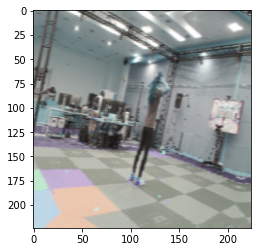

In [25]:
# train 데이터 확인
train_image , target = train_data.__getitem__(0)
np.array(train_image).shape
target_array = np.array(target['keypoints'][0][:,:2])
plt.imshow(np.array(train_image).transpose(1,2,0))

In [31]:
#test data 확인
filename, test_img = test_data.__getitem__(0)
test_img = cv2.imread(np.array(test_data))
plt.imshow(test_img)

TypeError: Can't convert object of type 'numpy.ndarray' to 'str' for 'filename'

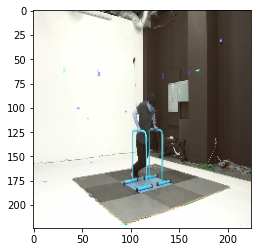

In [26]:
#test 확인
filename, test_img = test_data.__getitem__(0)
plt.imshow(np.array(test_img).transpose(1,2,0))

In [ ]:
# def draw_keypoints(
#     image: np.ndarray,
#     keypoints: np.ndarray,
#     edges: List[Tuple[int, int]] = None,
#     keypoint_names: Dict[int, str] = None, 
#     boxes: bool = True,
#     dpi: int = 200
# ) -> None:
#     """
#     Args:
#         image (ndarray): [H, W, C]
#         keypoints (ndarray): [N, 3]
#         edges (List(Tuple(int, int))): 
#     """
#     np.random.seed(42)
#     colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

#     if boxes:
#         x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
#         x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
#         cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

#     for i, keypoint in enumerate(keypoints):
#         cv2.circle(
#             image, 
#             tuple(keypoint), 
#             3,(255,0,0), thickness=3, lineType=cv2.FILLED)

#         if keypoint_names is not None:
#             cv2.putText(
#                 image, 
#                 f'{i}: {keypoint_names[i]}', 
#                 tuple(keypoint), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

#     if edges is not None:
#         for i, edge in enumerate(edges):
#             cv2.line(
#                 image, 
#                 tuple(keypoints[edge[0]]), 
#                 tuple(keypoints[edge[1]]),
#                 colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

#     fig, ax = plt.subplots(dpi=dpi)
#     ax.imshow(image)
#     ax.axis('off')
#     plt.show()
#     keypoints = target_array
# keypoint_names = {
#     0: 'nose',
#     1: 'left_eye',
#     2: 'right_eye',
#     3: 'left_ear', 
#     4: 'right_ear', 
#     5: 'left_shoulder', 
#     6: 'right_shoulder',
#     7: 'left_elbow', 
#     8: 'right_elbow',
#     9: 'left_wrist', 
#     10: 'right_wrist',
#     11: 'left_hip', 
#     12: 'right_hip',
#     13: 'left_knee', 
#     14: 'right_knee',
#     15: 'left_ankle', 
#     16: 'right_ankle',
#     17: 'neck', 
#     18: 'left_palm', 
#     19: 'right_palm', 
#     20: 'spine2(back)',
#     21: 'spine1(waist)', 
#     22: 'left_instep',
#     23: 'right_instep'
# }

# edges = [
#     (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
#     (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
#     (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
#     (6, 12), (11, 12), (17, 20), (20, 21), 
# ]
# draw_keypoints(np.array(train_image).transpose(1,2,0), keypoints, edges, keypoint_names, boxes=False, dpi=400)